# Collect multiple force/torque measurements as end-effector moves around, train decision tree to predict expected force.

In [1]:
#!/usr/bin/env python
import rospy
from geometry_msgs.msg import WrenchStamped
import moveit_commander
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from scipy.spatial.transform import Rotation as R

Failed to import pyassimp, see https://github.com/ros-planning/moveit/issues/86 for more info


In [2]:
class FT_DATA_COLLECTOR:
    def __init__(self):
        
        self.robot = moveit_commander.RobotCommander()
        self.group_name = "red_arm"
        self.group = moveit_commander.MoveGroupCommander(self.group_name)
        
        rospy.init_node('listener', anonymous=True)

        rospy.Subscriber("/red/robotiq_ft_wrench", WrenchStamped, self.callback)
        self.f = []
        self.m = []
        self.theta = []
        rospy.spin()
        

    def callback(self,msg):
        pose = self.group.get_current_pose().pose
        theta = R.from_quat(np.array((pose.orientation.x,pose.orientation.y,pose.orientation.z,pose.orientation.w)))
        self.theta.append(theta.as_euler('zyx'))
        self.f.append(np.array((msg.wrench.force.x,msg.wrench.force.y,msg.wrench.force.z)))
        self.m.append(np.array((msg.wrench.torque.x,msg.wrench.torque.y,msg.wrench.torque.z)))
        
        if (len(self.f) > 1000):
            rospy.signal_shutdown('Got 5000 samples')
    

In [3]:
data_collect = FT_DATA_COLLECTOR()

In [4]:
F = np.array(data_collect.f)
T = np.array(data_collect.m)
theta = np.array(data_collect.theta)

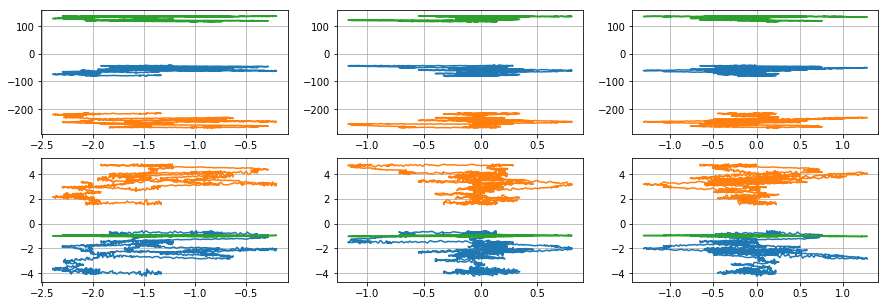

In [3]:
plt.figure(figsize=(15,5))
plt.subplot(2,3,1)
plt.plot(theta[:,0],F[:,0])
plt.plot(theta[:,0],F[:,1])
plt.plot(theta[:,0],F[:,2])
plt.grid()
plt.subplot(2,3,2)
plt.plot(theta[:,1],F[:,0])
plt.plot(theta[:,1],F[:,1])
plt.plot(theta[:,1],F[:,2])
plt.grid()
plt.subplot(2,3,3)
plt.plot(theta[:,2],F[:,0])
plt.plot(theta[:,2],F[:,1])
plt.plot(theta[:,2],F[:,2])
plt.grid()
plt.subplot(2,3,4)
plt.plot(theta[:,0],T[:,0])
plt.plot(theta[:,0],T[:,1])
plt.plot(theta[:,0],T[:,2])
plt.grid()
plt.subplot(2,3,5)
plt.plot(theta[:,1],T[:,0])
plt.plot(theta[:,1],T[:,1])
plt.plot(theta[:,1],T[:,2])
plt.grid()
plt.subplot(2,3,6)
plt.plot(theta[:,2],T[:,0])
plt.plot(theta[:,2],T[:,1])
plt.plot(theta[:,2],T[:,2])
plt.grid()
plt.show()

In [6]:
np.savetxt('F_%s.txt'%data_collect.group_name,F)
np.savetxt('T_%s.txt'%data_collect.group_name,T)
np.savetxt('theta_%s.txt'%data_collect.group_name,theta)

In [2]:
F = np.genfromtxt('../data/F_red_arm.txt')
T = np.genfromtxt('../data/T_red_arm.txt')
theta = np.genfromtxt('../data/theta_red_arm.txt')

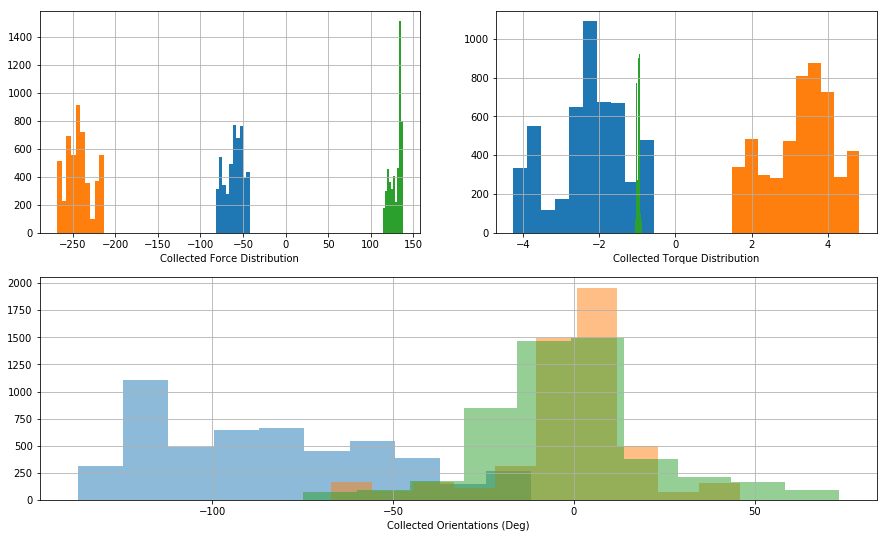

In [3]:
plt.figure(figsize=(15,9))
plt.subplot(2,2,1)
plt.hist(F[:,0])
plt.hist(F[:,1])
plt.hist(F[:,2])
plt.grid()
plt.xlabel('Collected Force Distribution')
plt.subplot(2,2,2)
plt.hist(T[:,0])
plt.hist(T[:,1])
plt.hist(T[:,2])
plt.xlabel('Collected Torque Distribution')
plt.grid()
plt.subplot(2,1,2)
plt.hist(theta[:,0]*180/np.pi,alpha=0.5)
plt.hist(theta[:,1]*180/np.pi,alpha=0.5)
plt.hist(theta[:,2]*180/np.pi,alpha=0.5)
plt.xlabel('Collected Orientations (Deg)')
plt.grid()
plt.show()

In [4]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split

In [18]:
#dt = DecisionTreeRegressor(max_depth=20)
#dt = RandomForestRegressor(max_depth=20,n_estimators=200)
dt = KNeighborsRegressor(n_neighbors=1)

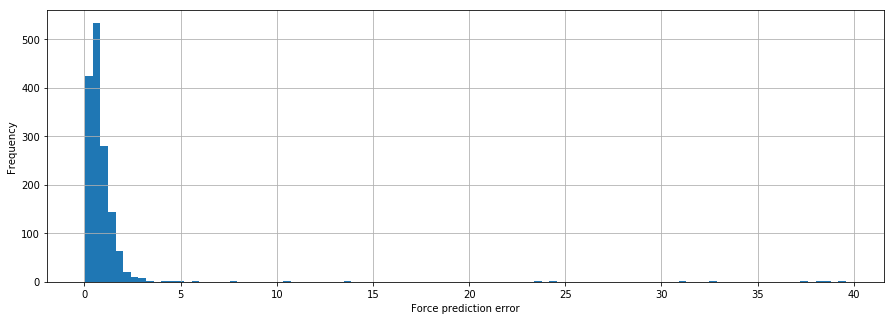

In [19]:
X_train, X_test, y_train, y_test = train_test_split(theta, F, test_size=0.3)
dt.fit(X_train,y_train)

ypred = dt.predict(X_test)

plt.figure(figsize=(15,5))
plt.hist(np.sqrt(np.sum((ypred-y_test)**2,axis=1)),bins=100)
plt.grid()
plt.ylabel('Frequency')
plt.xlabel('Force prediction error')
plt.show()

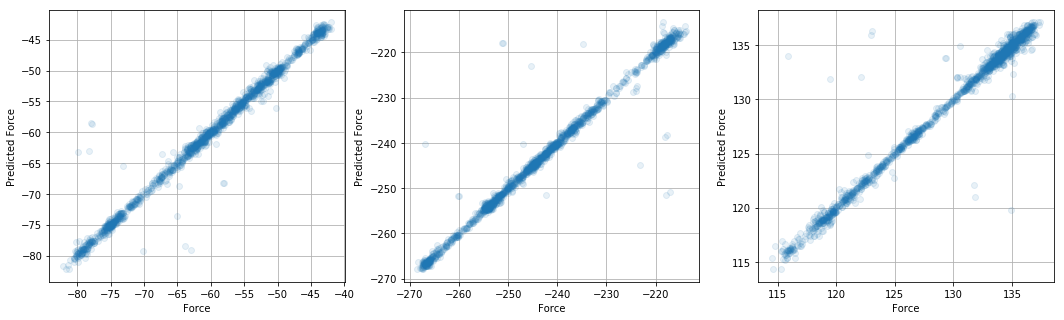

In [20]:
plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
plt.plot(y_test[:,0],ypred[:,0],'o',alpha=0.1)
plt.grid()
plt.ylabel('Predicted Force')
plt.xlabel('Force')
plt.subplot(1,3,2)
plt.plot(y_test[:,1],ypred[:,1],'o',alpha=0.1)
plt.grid()
plt.ylabel('Predicted Force')
plt.xlabel('Force')
plt.subplot(1,3,3)
plt.plot(y_test[:,2],ypred[:,2],'o',alpha=0.1)
plt.grid()
plt.ylabel('Predicted Force')
plt.xlabel('Force')
plt.show()

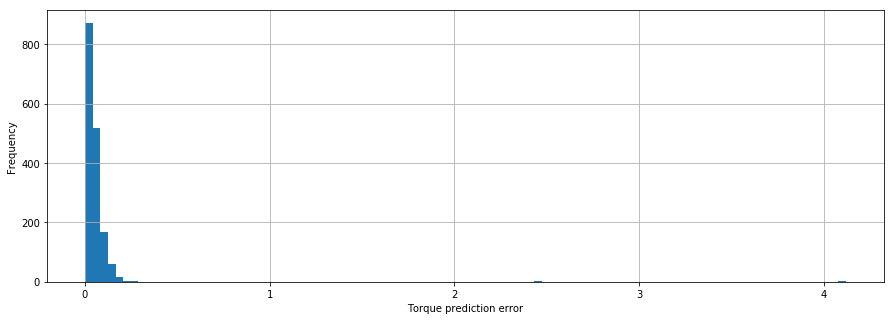

In [21]:
X_train, X_test, y_train, y_test = train_test_split(theta, T, test_size=0.33, random_state=42)
dt.fit(X_train,y_train)

ypred = dt.predict(X_test)

plt.figure(figsize=(15,5))
plt.hist(np.sqrt(np.sum((ypred-y_test)**2,axis=1)),bins=100)
plt.grid()
plt.ylabel('Frequency')
plt.xlabel('Torque prediction error')
plt.show()

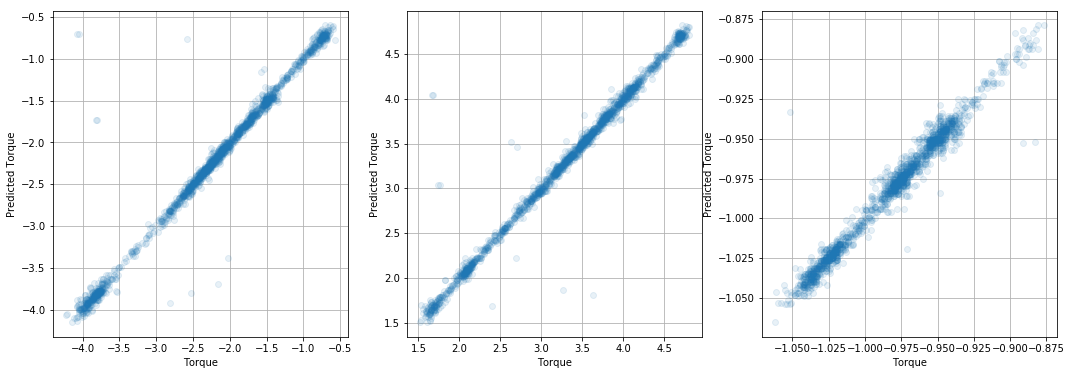

In [22]:
plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.plot(y_test[:,0],ypred[:,0],'o',alpha=0.1)
plt.grid()
plt.ylabel('Predicted Torque')
plt.xlabel('Torque')
plt.subplot(1,3,2)
plt.plot(y_test[:,1],ypred[:,1],'o',alpha=0.1)
plt.grid()
plt.ylabel('Predicted Torque')
plt.xlabel('Torque')
plt.subplot(1,3,3)
plt.plot(y_test[:,2],ypred[:,2],'o',alpha=0.1)
plt.grid()
plt.ylabel('Predicted Torque')
plt.xlabel('Torque')
plt.show()